## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

## Reading Epochs and preprocessing

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.resample(600).crop(0, None)
info = epochs.info

## Create a dataset containig epoched data

In [3]:
dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
del raw, epochs, epochs_list

## Split the dataset into train and test sets

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Create model, inheriting from BaseModel class

In [5]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

## Compile the model

In [13]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

Epoch 0:  loss_train:  0.7244   |    binary_accuracy_train:  0.5183   |    loss_val:  0.7053   |    binary_accuracy_val:  0.6119
Epoch 1:  loss_train:  0.6934   |    binary_accuracy_train:  0.6483   |    loss_val:  0.6770   |    binary_accuracy_val:  0.7060
Epoch 2:  loss_train:  0.6599   |    binary_accuracy_train:  0.7490   |    loss_val:  0.6464   |    binary_accuracy_val:  0.7542
Epoch 3:  loss_train:  0.6236   |    binary_accuracy_train:  0.7998   |    loss_val:  0.6139   |    binary_accuracy_val:  0.7989
Epoch 4:  loss_train:  0.5858   |    binary_accuracy_train:  0.8154   |    loss_val:  0.5803   |    binary_accuracy_val:  0.8044
Epoch 5:  loss_train:  0.5482   |    binary_accuracy_train:  0.8270   |    loss_val:  0.5461   |    binary_accuracy_val:  0.8297
Epoch 6:  loss_train:  0.5122   |    binary_accuracy_train:  0.8356   |    loss_val:  0.5128   |    binary_accuracy_val:  0.8378
Epoch 7:  loss_train:  0.4797   |    binary_accuracy_train:  0.8452   |    loss_val:  0.4842   | 

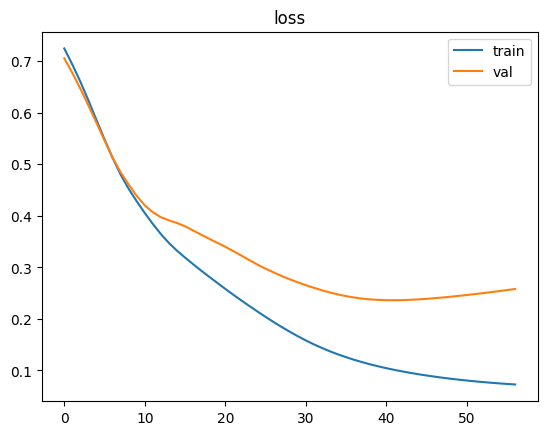

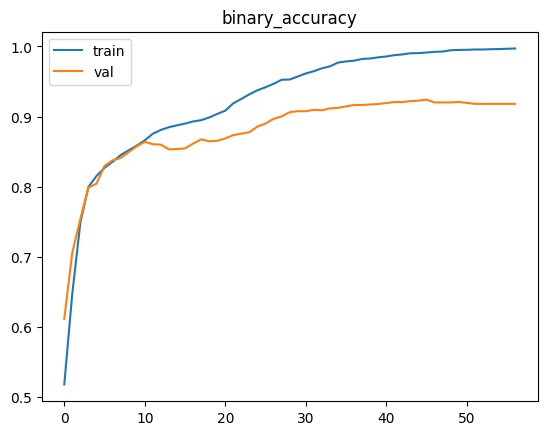

In [14]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [15]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14156516980041156
train_binary_accuracy: 0.9671984206546437
loss: 0.21611758863384073
binary_accuracy: 0.9399350610646334


## Make a prediction

#### Take a random sample from the test set

In [18]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 272


#### Make a prediction, print the predicted value and the actual label

In [19]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction: -3.74 | -6.82 | -6.93 |  3.41 | -7.61 | -9.65 | -6.59 | -11.13
Actual:      0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0  |  0.0  |  0.0 


## Model interpretation

In [20]:
interpreter = LFCNNInterpreter(model, test, info)

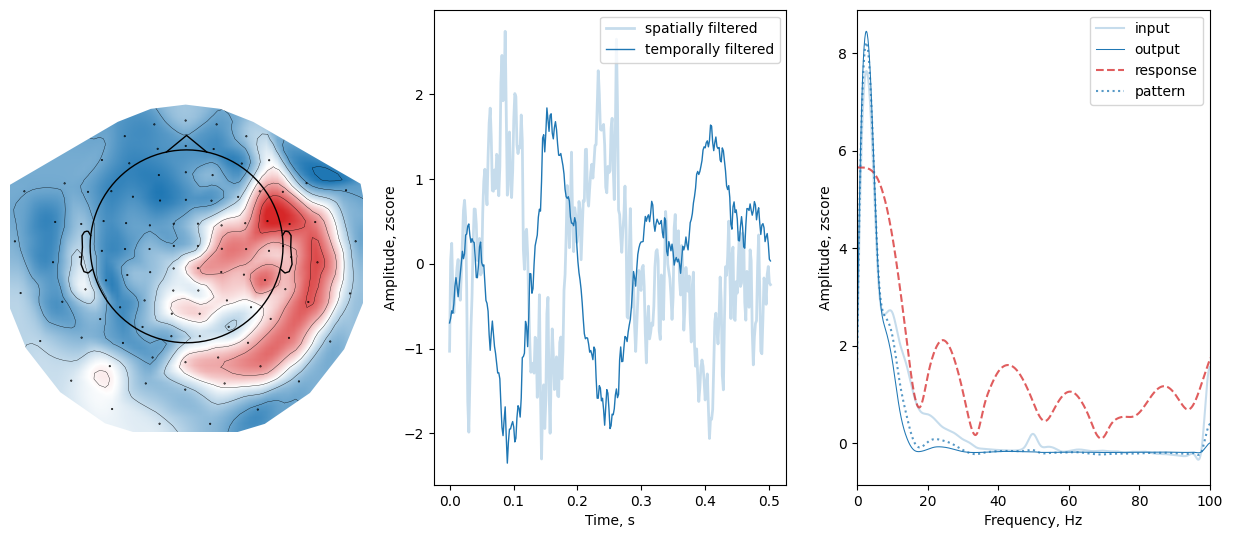

In [21]:
fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])